In [1]:
!pip install chart-studio --quiet

     |████████████████████████████████| 64 kB 3.1 MB/s 


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from chart_studio import plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mental Health/Mental-health-related-subreddits-modified.csv")
df.head()

,Content,Category,label
0,guys the civil war movies and games. keep givi...,schizophrenia,0
1,"What do I have? Hi everyone, I just found this...",anxiety,1
2,Buster from Arthur... A possibly random and we...,schizophrenia,0
3,anxiety attack at the movies I took about 50mg...,anxiety,1
4,Today’s reflections on depression I don’t know...,BPD,2


In [5]:
df.Category.value_counts()

anxiety          86132
depression       85994
bipolar          41052
BPD              38137
schizophrenia    17459
autism            7132
Name: Category, dtype: int64

In [6]:
df.shape

(275906, 3)

<Figure size 720x432 with 0 Axes>

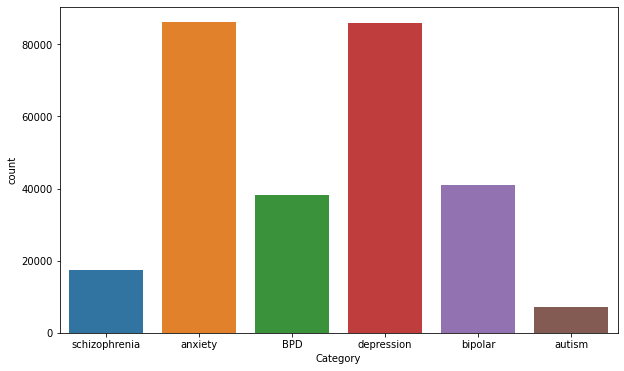

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x = 'Category', data=df)

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
def print_plot(index):
    example = df[df.index == index][['Content', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [10]:
print_plot(50)

Depressing Christmas Eve My mom had chemotherapy today and turns out the cancer she had was the most aggressive type there is and that it spreads the fastest. So it puts me and my brother at risk later in life and i know i shouldn't think about it now but it sucks to know. I also have to deal with my brother's pressuring into watching a movie and the unnecessary grumpiness and whinning of my dad. My mom's case just makes me feel like a shitty daughter and like i don't support her enough. It doesn't help that my dad doesn't even emotionally support her. This sucks.
Product: depression


In [11]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['Content'] = df['Content'].apply(clean_text)

In [12]:
df['Content'] = df['Content'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [13]:
print_plot(10)

im child adult body barely take care much less function wider world im awkward barely socialise ive never relationship done anything intimate girl chose course im uni easiest course ba didnt want stress continue coast like high school zero job eperience speak idea want life zero motivation ambitions aspirations free time play video games watch tv anime live everyday waiting net distraction carry net weeks whether new tv show video game younger siblings much adjusted still feel angst pointlessness life anger toward shortcomings high schooler supposed survive real world wants person
Product: depression


In [14]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 292585 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(df['Content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (275906, 1000)


In [16]:
Y = df['label']
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (275906,)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(220724, 1000) (220724,)
(55182, 1000) (55182,)


In [18]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
from tensorflow.keras.utils import plot_model

MAX_FEATURES = 20001
maxTextLen = 1000

def build_lstm_model():
  model = Sequential()
  model.add(Embedding(MAX_FEATURES, 100, input_length=maxTextLen))
  #model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True))
  model.add(Dropout(0.5))
  model.add(Dense(units=64, activation="relu"))

  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

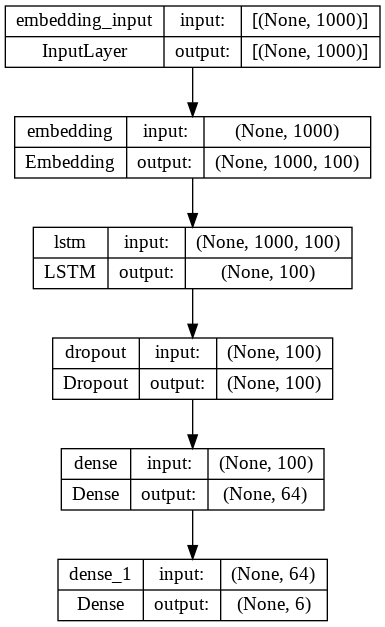

In [19]:
model = build_lstm_model()
plot_model(model,show_shapes=True)

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2000100   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,087,354
Trainable params: 2,087,354
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# model.compile(optimizer='sgd',
#               loss = tf.keras.losses.CosineSimilarity(axis=1),
#               metrics = ['accuracy'])

In [22]:
possible_labels = ['schizophrenia', 'anxiety', 'BPD', 'depression', 'bipolar',
       'autism']

In [23]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix
def showResults(test, pred):
    print(classification_report(test, pred, target_names=possible_labels))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("F1-score : {}".format(f1Score))
    cm=confusion_matrix(test, pred)
    print(cm)
    print("\n")

In [24]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

epochs=20
batch_size=1000

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(x_train, y_train)
foldNum=0
for train_index, val_index in skf.split(x_train, y_train):
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # one hot encode
    Y_train = to_categorical(Y_train)
    Y_val = to_categorical(Y_val)
    
    lstm_history = model.fit(X_train, Y_train, 
                        validation_data = (X_val, Y_val), 
                        epochs=epochs, 
                        batch_size=batch_size)  
    y_predict = model.predict(X_val)

    #Converting one hot encoded test label to label    
    pred = np.argmax(y_predict, axis=1)
    val = np.argmax(Y_val, axis=1)
    
    showResults(val, pred)

10

Results for fold 1
Epoch 1/20
199/199 [==============================] - 62s 277ms/step - loss: 1.2583 - accuracy: 0.5130 - val_loss: 0.9532 - val_accuracy: 0.6496
Epoch 2/20
199/199 [==============================] - 58s 294ms/step - loss: 0.9389 - accuracy: 0.6766 - val_loss: 0.8398 - val_accuracy: 0.7255
Epoch 3/20
199/199 [==============================] - 59s 295ms/step - loss: 0.7398 - accuracy: 0.7604 - val_loss: 0.7226 - val_accuracy: 0.7693
Epoch 4/20
199/199 [==============================] - 59s 299ms/step - loss: 0.6894 - accuracy: 0.7799 - val_loss: 0.7203 - val_accuracy: 0.7708
Epoch 5/20
199/199 [==============================] - 59s 298ms/step - loss: 0.6320 - accuracy: 0.8041 - val_loss: 0.7927 - val_accuracy: 0.7457
Epoch 6/20
199/199 [==============================] - 59s 295ms/step - loss: 0.7226 - accuracy: 0.7788 - val_loss: 0.7789 - val_accuracy: 0.7510
Epoch 7/20
199/199 [==============================] - 59s 296ms/step - loss: 0.6792 - accuracy: 0.7855 - val_lo

In [25]:
import pickle

with open ('/content/drive/MyDrive/Colab Notebooks/Mental Health/Final_k-fold_lstm_model_main-modified.pkl', 'wb') as f:
  pickle.dump(model, f)

In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

data= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Mental health/Mental-health-related-subreddits-modified.csv")
le = LabelEncoder()
labelEncode = le.fit_transform(data["Category"])

FileNotFoundError: ignored

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred = np.argmax(y_pred, axis=-1) 

In [ ]:
y_test=np.argmax(y_test, axis=-1)

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(x_train,y_train,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))

In [ ]:
# loss_and_metrics = model.evaluate(x_test,y_test,batch_size=256)
# print("The test accuracy is: "+str(loss_and_metrics[1]))

In [ ]:
# from sklearn import metrics
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# import seaborn as sns

# cnn_model = metrics.confusion_matrix(y_test, y_pred)

# cm_df = pd.DataFrame(cnn_model,index = ['Anxiety' ,'BPD' ,'autism', 'bipolar','depression', 'schizophrenia'], 
#                      columns = ['Anxiety' ,'BPD' ,'autism', 'bipolar','depression', 'schizophrenia'])

# plt.figure(figsize=(16, 10))
# sns.heatmap(cm_df, annot=True, fmt=".3f");
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score LSTM: {0}'.format(loss_and_metrics[1])
# plt.title(all_sample_title, size = 15);

# report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
# report = report.rename(index={'0': 'Anxiety','1':'BPD','2':'autism','3':'bipolar','4':'depression','5':'schizophrenia'})
# report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
# display(report)

In [ ]:
history_dict = lstm_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = lstm_history.epoch

plt.figure(figsize=(9,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(9,6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))